## Word embeddings

When dealing with words in text, we can end up with tens of thousands of word classes to analyze; one for each word in a vocabulary. Trying to one-hot encode these words is massively inefficient because most values in a one-hot vector will be set to zero. So, the matrix multiplication that happens in between a one-hot input vector and a first, hidden layer will result in mostly zero-valued hidden outputs.

To solve this problem and greatly increase the efficiency of our networks, we use what are called **embeddings**.We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.
 
A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.

---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.

Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

In this implementation, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

In [7]:
# read in the extracted text file
# Have trained this network using some text data from wikipedia

with open('/Users/vivekkumarmaheshwari/new_data.txt') as f:
    text = f.read()

# print out the first 100 characters
print(text[:100])

and founded st paul s cathedral he was driven from london by the heathen sons of king sebert of esse


In [8]:
import re
from collections import Counter

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab


# get list of words
words = preprocess(text)
print(words[:30])

['and', 'founded', 'st', 'paul', 's', 'cathedral', 'he', 'was', 'driven', 'from', 'london', 'by', 'the', 'sons', 'of', 'king', 'of', 'after', 'he', 'refused', 'the', 'brothers', 'request', 'for', 'a', 'taste', 'of', 'the', 'bread', 'he']


In [9]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 175995
Unique words: 4191


In [10]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[2, 591, 388, 627, 12, 1216, 27, 13, 2409, 22, 941, 16, 0, 2410, 1, 142, 1, 61, 27, 1159, 0, 2411, 1761, 15, 4, 3616, 1, 0, 2634, 27]


In [11]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

# discard some frequent words, according to the subsampling equation
# create a new list of words for training
total_words = len(int_words)
freqs = {word: count/total_words for word, count in word_counts.items()}
drop_prob = {word: (1 - np.sqrt(threshold/freqs[word])) for word in word_counts}

#discarding some frequent words, for subsampling

train_words = [word for word in int_words if random.random() < (1 - drop_prob[word])]
print(train_words[:30])

(2, 5099)
[2409, 2410, 142, 2411, 3616, 2634, 3202, 470, 360, 3202, 3203, 1551, 3203, 607, 133, 3203, 3203, 275, 2242, 3205, 133, 1099, 207, 1098, 340, 330, 557, 2412, 608, 2885]


In [12]:
def get_target(words, idx, window_size=5):
    
    
    R = np.random.randint(1, window_size+1)
    start_index = idx - R if (idx - R) > 0 else 0
    end_index = idx + R
    target_words = words[start_index:idx] + words[idx+1:end_index+1]
    
    return list(target_words)

In [13]:
# testing
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]


In [14]:
def get_batches(words, batch_size, window_size=5):
    n_batches = len(words)//batch_size
    
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [15]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 1, 2]


In [16]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [17]:
import torch
from torch import nn
import torch.optim as optim

In [18]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)

    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [19]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 2000

# train for some number of epochs
for e in range(epochs):
    # get input and target batches
    print("epoch: ", e)
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
s | internal, derived, motion, gain, phase
than | shortly, problems, heavily, appearance, conversion
i | promoting, tracks, white, candidate, leading
an | roman, wing, researchers, canberra, increasingly
after | immediate, mere, tenochtitlan, regard, camp
use | host, malware, militia, implemented, steven
other | category, violation, atlanta, type, several
him | completely, drug, assuming, rank, split
experiment | track, le, trilogy, remained, occupied
graham | faith, complete, screen, occurred, committee
go | expanded, argued, fishing, anthropomorphic, easily
attempt | second, menorah, extended, lives, meher
turn | systems, japan, perestroika, ran, with
expected | midas, seen, aspects, canadian, tdi
pete | corresponds, factors, coverage, researchers, captain
theater | designs, quest, unique, honor, mystery
...
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
e

In [20]:
# we have used T-SNE to visualize how our high-dimensional word vectors cluster together. 
# It is used to project these vectors into two dimensions while preserving local stucture.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [21]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [22]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

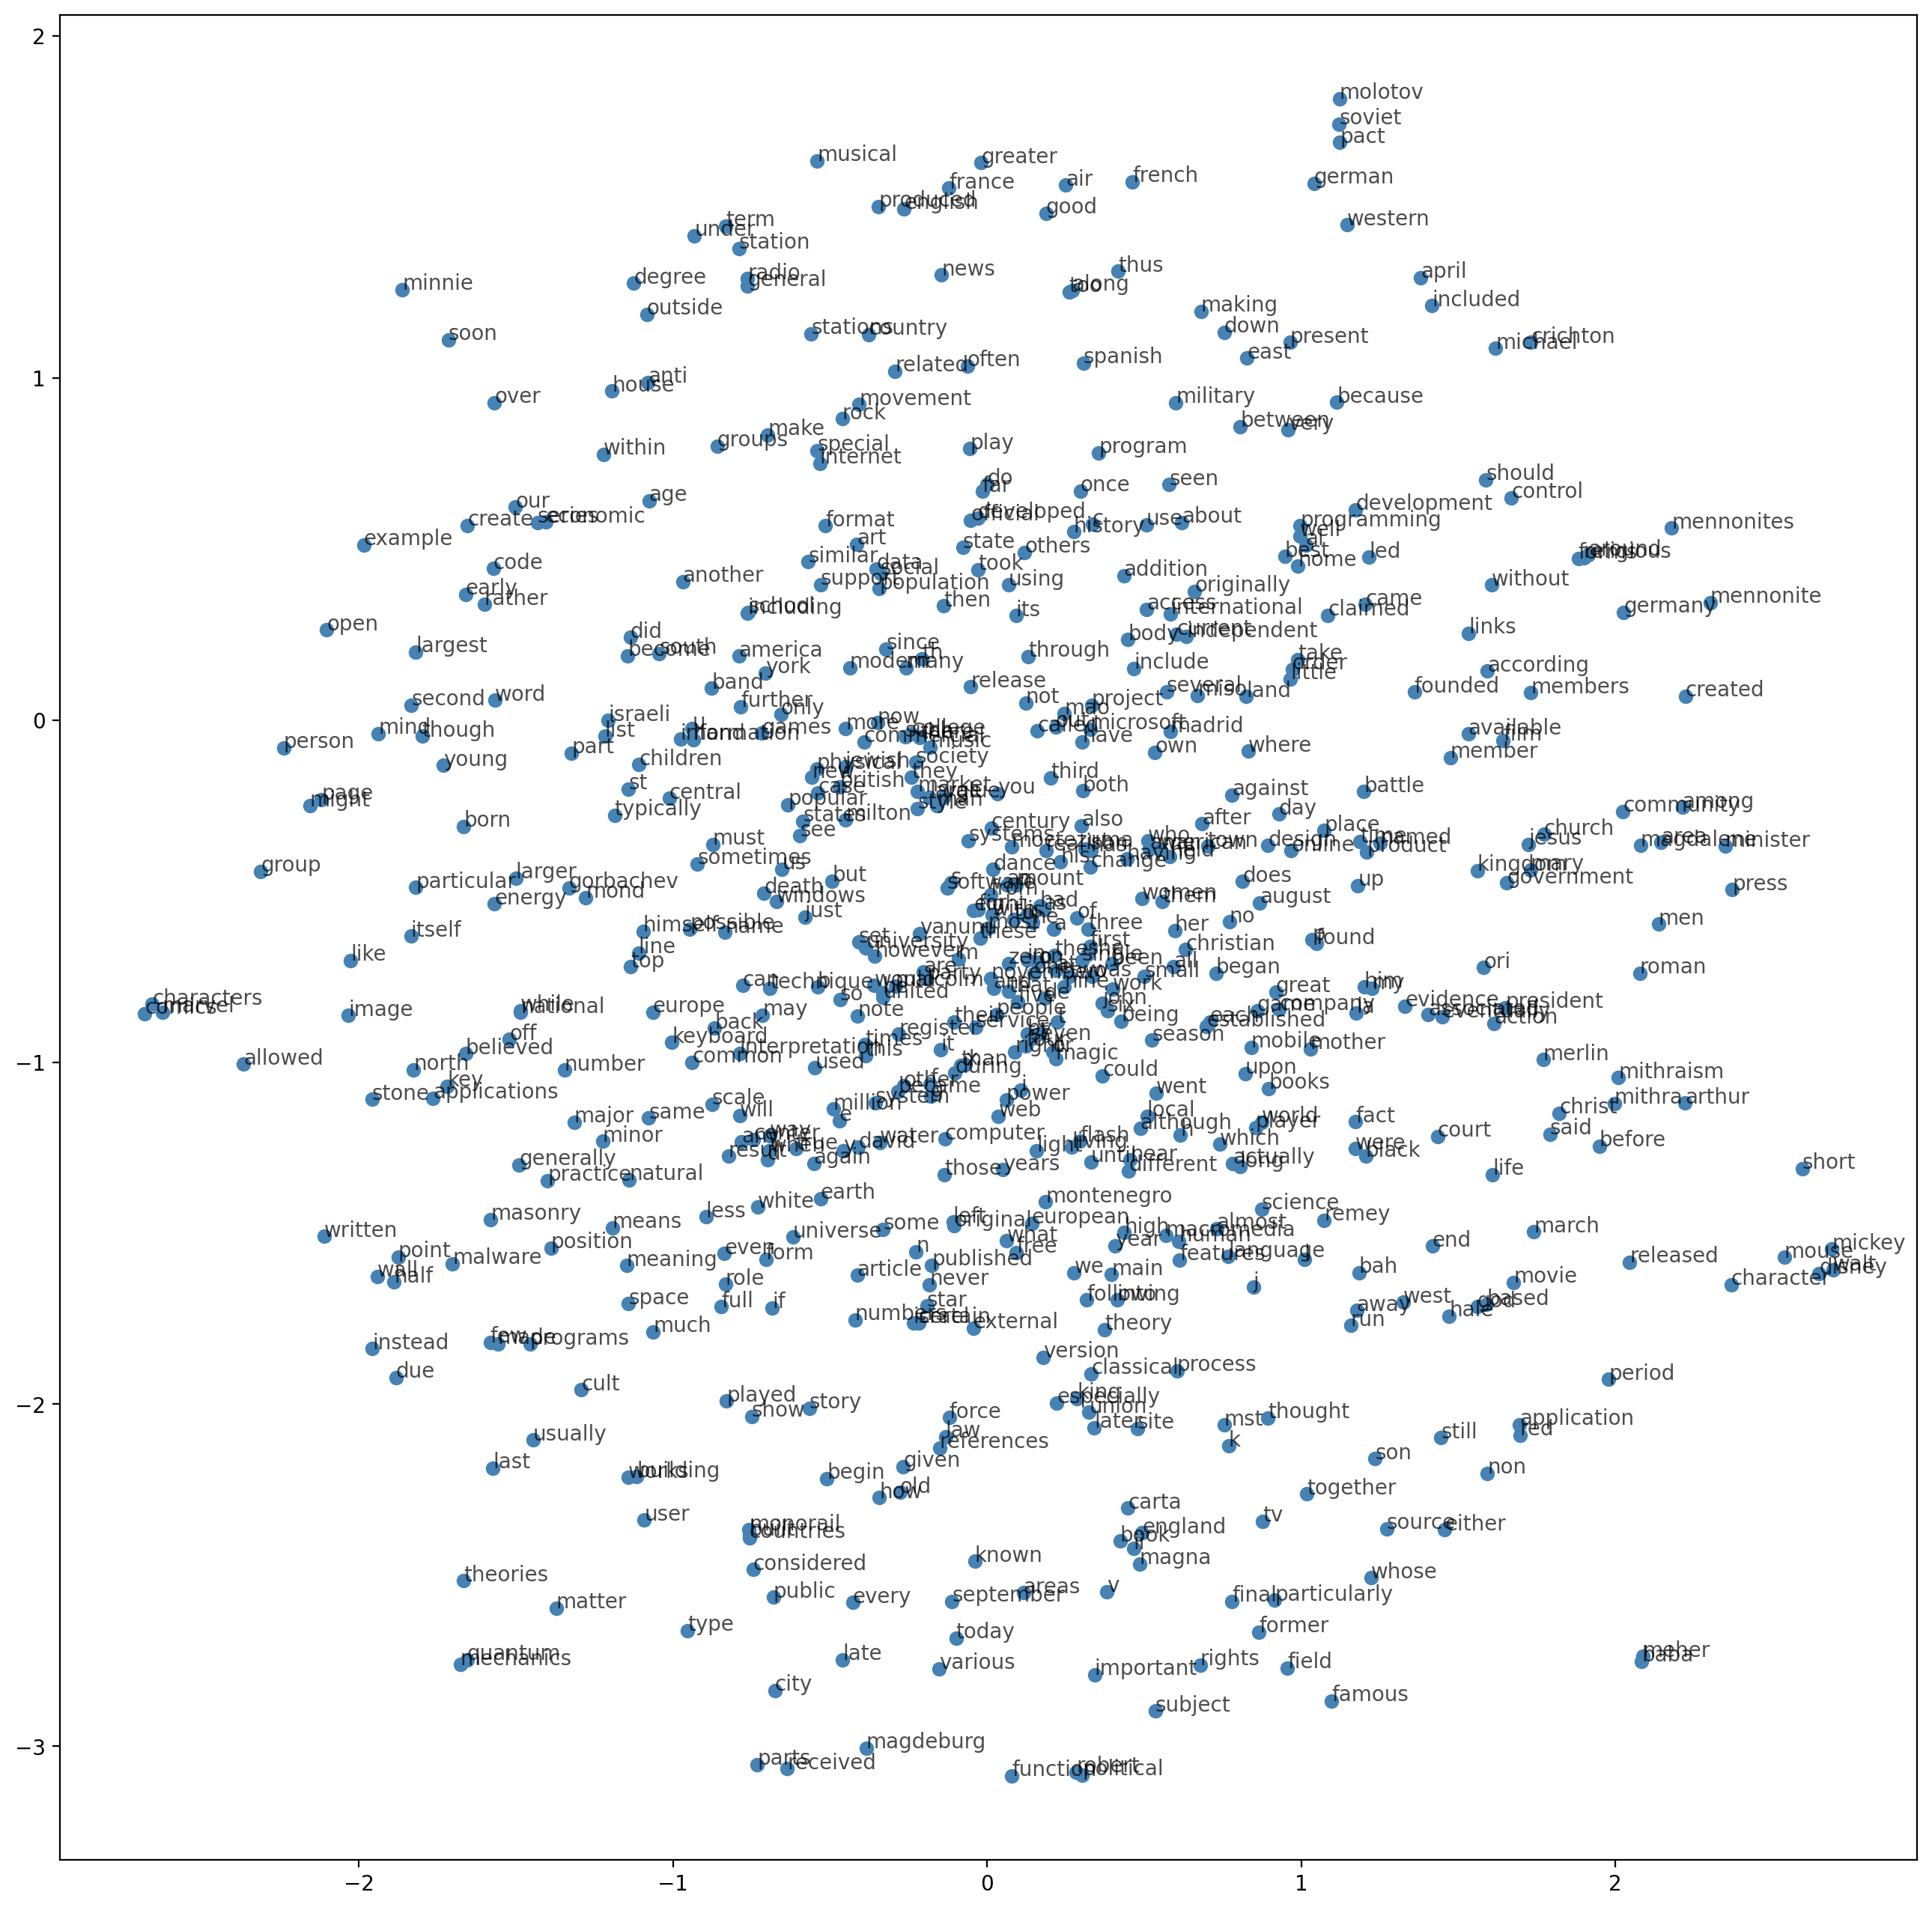

In [23]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)